In [1]:
import math
import numpy as np

In [2]:
def gradient_descent(start, loss=None, dx=0.00001, learning_rate=0.01, tol=0.00001, max_iter=1000, grad_loss=None):
    x = start
    step = []
    gradients = []
    last_gradient = np.ones(np.size(x)) * np.inf
    
    for _ in range(max_iter):
        step.append(np.copy(x))
        if grad_loss != None:
            gradient = grad_loss(x)
        else:
            if loss == None:
                print("Loss function must be given if loss gradient is not given!")
                return
            gradient = (loss(x+dx) - loss(x-dx)) / (2*dx)
        gradients.append(gradient)
        if np.all(abs(gradient - last_gradient) < tol):
            break
        last_gradient = gradient
        x -= learning_rate * gradient
        
    return step, gradients, x

Let's start with a simple convex function to test if my implementation is correct.

In [3]:
def func1(x):
    return x**2 + 2*x + 1

def grad_func1(x):
    return 2*x + 2

In [4]:
step, gradients, x = gradient_descent(10, func1)
print(x)

step, gradients, x = gradient_descent(10, func1, grad_loss=grad_func1)
print(x)

-0.9997587658000606
-0.9997587658001656


Now, to check if -1 is indeed the minimum point of func1.

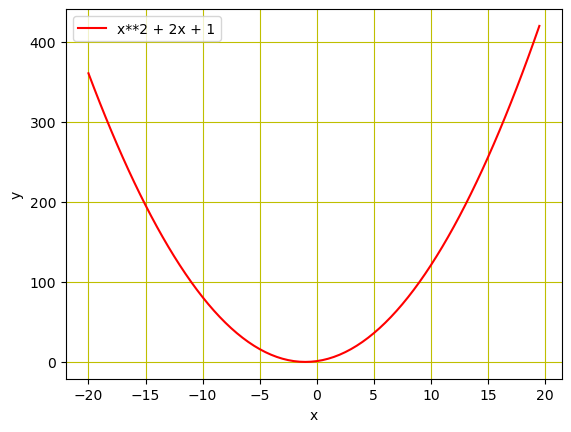

In [5]:
import matplotlib.pyplot as plt

x = np.arange(-20, 20, 0.5)
y = [func1(i) for i in x]

plt.plot(x, y, 'r', label='x**2 + 2x + 1')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid('True', color='y')
plt.show()

Since the lowest point of the equation is -1, it's safe to say that my implementation is correct for THIS PARTICULAR EQUATION.

Now, let's try with more examples. Scipy.optimize.fmin can be used to verify the minimum of an equation.

In [6]:
import random
from scipy import optimize

In [7]:
n = 100
success_count = 0
failed = []
learning_rate = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
for _ in range(100):
    success = False
    degree = random.randint(1,2) * 2 # degree 2 or 4
    coefficient = []
    for _ in range(degree):
        coefficient.append(random.randint(1,5))
    def random_func(x):
        ans = 0
        for i in range(1, degree+1):
            ans += x**i * coefficient[i-1]
        return ans
    for rate in learning_rate:
        step, gradients, minima = gradient_descent(0, random_func, learning_rate=rate)
        minimum = optimize.fmin(random_func, 0, disp=False)
        if abs(minima - minimum) < 0.1:
            success_count += 1
            success = True
            break
    if not success:
        failed.append((coefficient, minima, minimum))

In [8]:
print(success_count, failed)

100 []


The function below can be used to print out graphs for failed attempt.

In [9]:
def func(x, coefficient):
    ans = 0
    degree = len(coefficient)
    for i in range(degree):
        ans += x**(i+1) * coefficient[i]
    return ans

for (coefficient, minima, minimum) in failed:
    x = np.arange(-10, 10, 0.05)
    y = [func(i, coefficient) for i in x]
    plt.plot(minima, func(minima, coefficient), marker='x')
    plt.plot(minimum, func(minimum, coefficient), marker='+')
    plt.plot(x, y)
    plt.show()

Well, it has succeeded for 100 times. Therefore, I say it is good enough for now.

However, we can do better IF PyTorch is used.

In [10]:
import torch

We can approximate the coefficient of a 3rd degree polynomial using gradient descent.

To do this, we need to define our loss as the MSE of the real equation and the approximate.

In [11]:
p = -5
q = 5

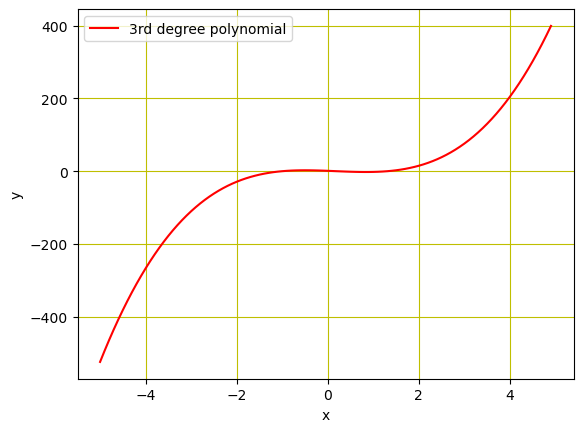

In [12]:
x = torch.arange(p, q, 0.1)
y = 1 - 5*x - 2*x*x + 4*x**3
plt.plot(x.numpy(), y.numpy(), 'r', label='3rd degree polynomial')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid('True', color='y')
plt.show()

In [13]:
def forward(x):
    return b + w0*x + w1*(x*x) + w2*(x*x*x)

def MSE(y_pred, y):
    return torch.mean((y_pred - y)**2)

We have prepared the data, weight, bias, forward and loss function. Now, we can start the game.

In [14]:
learning_rate = 0.0001
max_iter = 10000

w0 = torch.tensor(-1.0, requires_grad=True)
w1 = torch.tensor(-0.5, requires_grad=True)
w2 = torch.tensor(-0.5, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)
last_loss = torch.tensor(np.inf, requires_grad=False)
tol = 0.0001

for _ in range(max_iter):
    y_pred = forward(x)
    loss = MSE(y_pred, y)
    loss.backward()
    b.data = b.data - learning_rate*b.grad.data
    b.grad.data.zero_()
    w0.data = w0.data - learning_rate*w0.grad.data
    w0.grad.data.zero_()
    w1.data = w1.data - learning_rate*w1.grad.data
    w1.grad.data.zero_()
    w2.data = w2.data - learning_rate*w2.grad.data
    w2.grad.data.zero_()
    if abs(last_loss - loss) < tol:
        break
    else:
        last_loss = loss
print(b.item(), w0.item(), w1.item(), w2.item())

0.7580564022064209 -4.6343817710876465 -1.9852759838104248 3.9795985221862793


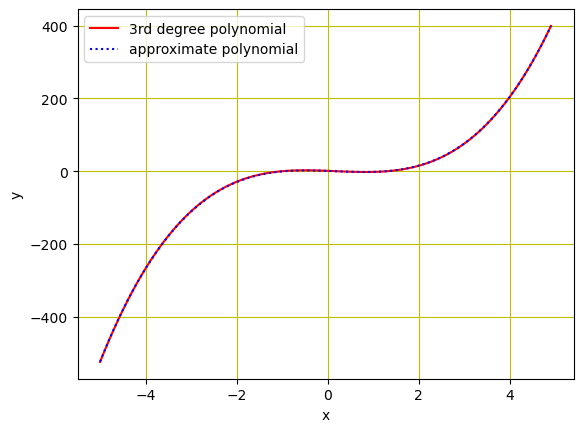

In [15]:
plt.plot(x.numpy(), y.numpy(), 'r', label='3rd degree polynomial')
plt.plot(x.numpy(), forward(x).detach().numpy(), 'b', label='approximate polynomial', linestyle='dotted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid('True', color='y')
plt.show()

As shown on the graph above, our approximation seems to be pretty accurate.